In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Mounted at /content/gdrive


In [2]:
!ln -fs /content/gdrive/My\ Drive/Tensorflow2/MMSLAB-TF2/ /app  #執行一次就可，否則會有錯誤訊息

In [3]:
%cd /app

/content/gdrive/My Drive/Tensorflow2/MMSLAB-TF2


In [4]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [6]:
from keras.datasets import imdb

In [7]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [8]:
print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("_"*100)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)
print("_"*100)
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in train_data]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in train_data]))

train_data  (25000,)
train_labels  (25000,)
____________________________________________________________________________________________________
test_data  (25000,)
test_labels  (25000,)
____________________________________________________________________________________________________
Maximum value of a word index 
9999
Maximum length num words of review in train 
2494


In [9]:
# See an actual review in words
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)

word_index = imdb.get_word_index()

reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join(
[reverse_word_index.get(i - 3, '?') for i in train_data[123]])

print(decoded_review)

1646592/1641221 [==============================] - 0s 0us/step
? beautiful and touching movie rich colors great settings good acting and one of the most charming movies i have seen in a while i never saw such an interesting setting when i was in china my wife liked it so much she asked me to ? on and rate it so other would enjoy too


In [10]:
# VECTORIZE as one cannot feed integers into a NN 
# Encoding the integer sequences into a binary matrix - one hot encoder basically
# From integers representing words, at various lengths - to a normalized one hot encoded tensor (matrix) of 10k columns

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (25000, 10000)
x_test  (25000, 10000)


In [12]:
# VECTORIZE the labels too - NO INTEGERS only floats into a tensor...(rare exceptions)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)


In [13]:
# Set a VALIDATION set

x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (10000, 10000)
partial_x_train  (15000, 10000)
y_val  (10000,)
partial_y_train  (15000,)


In [14]:
def mean_squared_error2(y_true, y_pred):
    return K.mean(K.square(K.square(y_pred-y_true)),axis=-1)

In [15]:
inputs = keras.Input(shape=(10000, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度類別數量，並且使用sigmoid激活函數
# outputs = layers.Dense(1, activation='sigmoid')(x)
outputs = layers.Dense(1)(x)


# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構


Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

In [17]:
model_dir = '/app/myloss-logs/models'  # 設定儲存權重目錄
!rm -rf /app/myloss-logs
os.makedirs(model_dir)  # 創建儲存權重目錄

In [18]:
# 儲存訓練記錄檔
log_dir = os.path.join('/app/myloss-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

In [19]:
model_1.compile(keras.optimizers.Adam(),
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=[keras.metrics.BinaryAccuracy()])

In [20]:
history_1 = model_1.fit(x_train, y_train, 
                batch_size=64 ,
                epochs=50, 
                validation_data=(x_val, y_val),
                callbacks=[model_cbk, model_mckp])

Epoch 1/50
  1/391 [..............................] - ETA: 0s - loss: 0.6934 - binary_accuracy: 0.6094WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
391/391 [==============================] - 3s 7ms/step - loss: 0.3722 - binary_accuracy: 0.8216 - val_loss: 0.1897 - val_binary_accuracy: 0.9419
Epoch 2/50
391/391 [==============================] - 2s 5ms/step - loss: 0.2028 - binary_accuracy: 0.9220 - val_loss: 0.1016 - val_binary_accuracy: 0.9655
Epoch 3/50
391/391 [==============================] - 2s 5ms/step - loss: 0.1329 - binary_accuracy: 0.9514 - val_loss: 0.0469 - val_binary_accuracy: 0.9860
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: 0.0866 - binary_accuracy: 0.9701 - val_loss: 0.0333 - val_binary_accuracy: 0.9919
Epoch 5

In [21]:
inputs = keras.Input(shape=(10000, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度為類別數量，並且使用sigmoid激活函數
outputs = layers.Dense(1)(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)

# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

In [22]:
# 儲存訓練記錄檔
log_dir = os.path.join('/app/myloss-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                         monitor='val_binary_accuracy', 
                                         save_best_only=True, 
                                         mode='max')

In [41]:
from keras import backend as K
num_classes=2

In [42]:
def mycrossentropy(y_true, y_pred, e=0.1):
    return (1-e)*keras.losses.binary_crossentropy(y_pred,y_true) + e*keras.losses.binary_crossentropy(y_pred, K.ones_like(y_pred)/num_classes)

In [43]:
model_2.compile(keras.optimizers.Adam(),
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=mycrossentropy,
               metrics=[keras.metrics.BinaryAccuracy()])

In [44]:
history_2 = model_2.fit(x_train, y_train, 
                batch_size=64 ,
                epochs=50, 
                validation_data=(x_val, y_val),
                callbacks=[model_cbk, model_mckp])

Epoch 1/50
391/391 [==============================] - 3s 9ms/step - loss: -9097320.0000 - binary_accuracy: 0.6114 - val_loss: -70699912.0000 - val_binary_accuracy: 0.6300
Epoch 2/50
391/391 [==============================] - 2s 6ms/step - loss: -970895488.0000 - binary_accuracy: 0.6246 - val_loss: -3308238080.0000 - val_binary_accuracy: 0.6310
Epoch 3/50
391/391 [==============================] - 2s 6ms/step - loss: -11501504512.0000 - binary_accuracy: 0.6244 - val_loss: -26210795520.0000 - val_binary_accuracy: 0.6018
Epoch 4/50
391/391 [==============================] - 2s 6ms/step - loss: -55579156480.0000 - binary_accuracy: 0.6156 - val_loss: -101989040128.0000 - val_binary_accuracy: 0.6218
Epoch 5/50
391/391 [==============================] - 2s 6ms/step - loss: -174330478592.0000 - binary_accuracy: 0.6188 - val_loss: -280826314752.0000 - val_binary_accuracy: 0.6148
Epoch 6/50
391/391 [==============================] - 2s 6ms/step - loss: -422389317632.0000 - binary_accuracy: 0.622

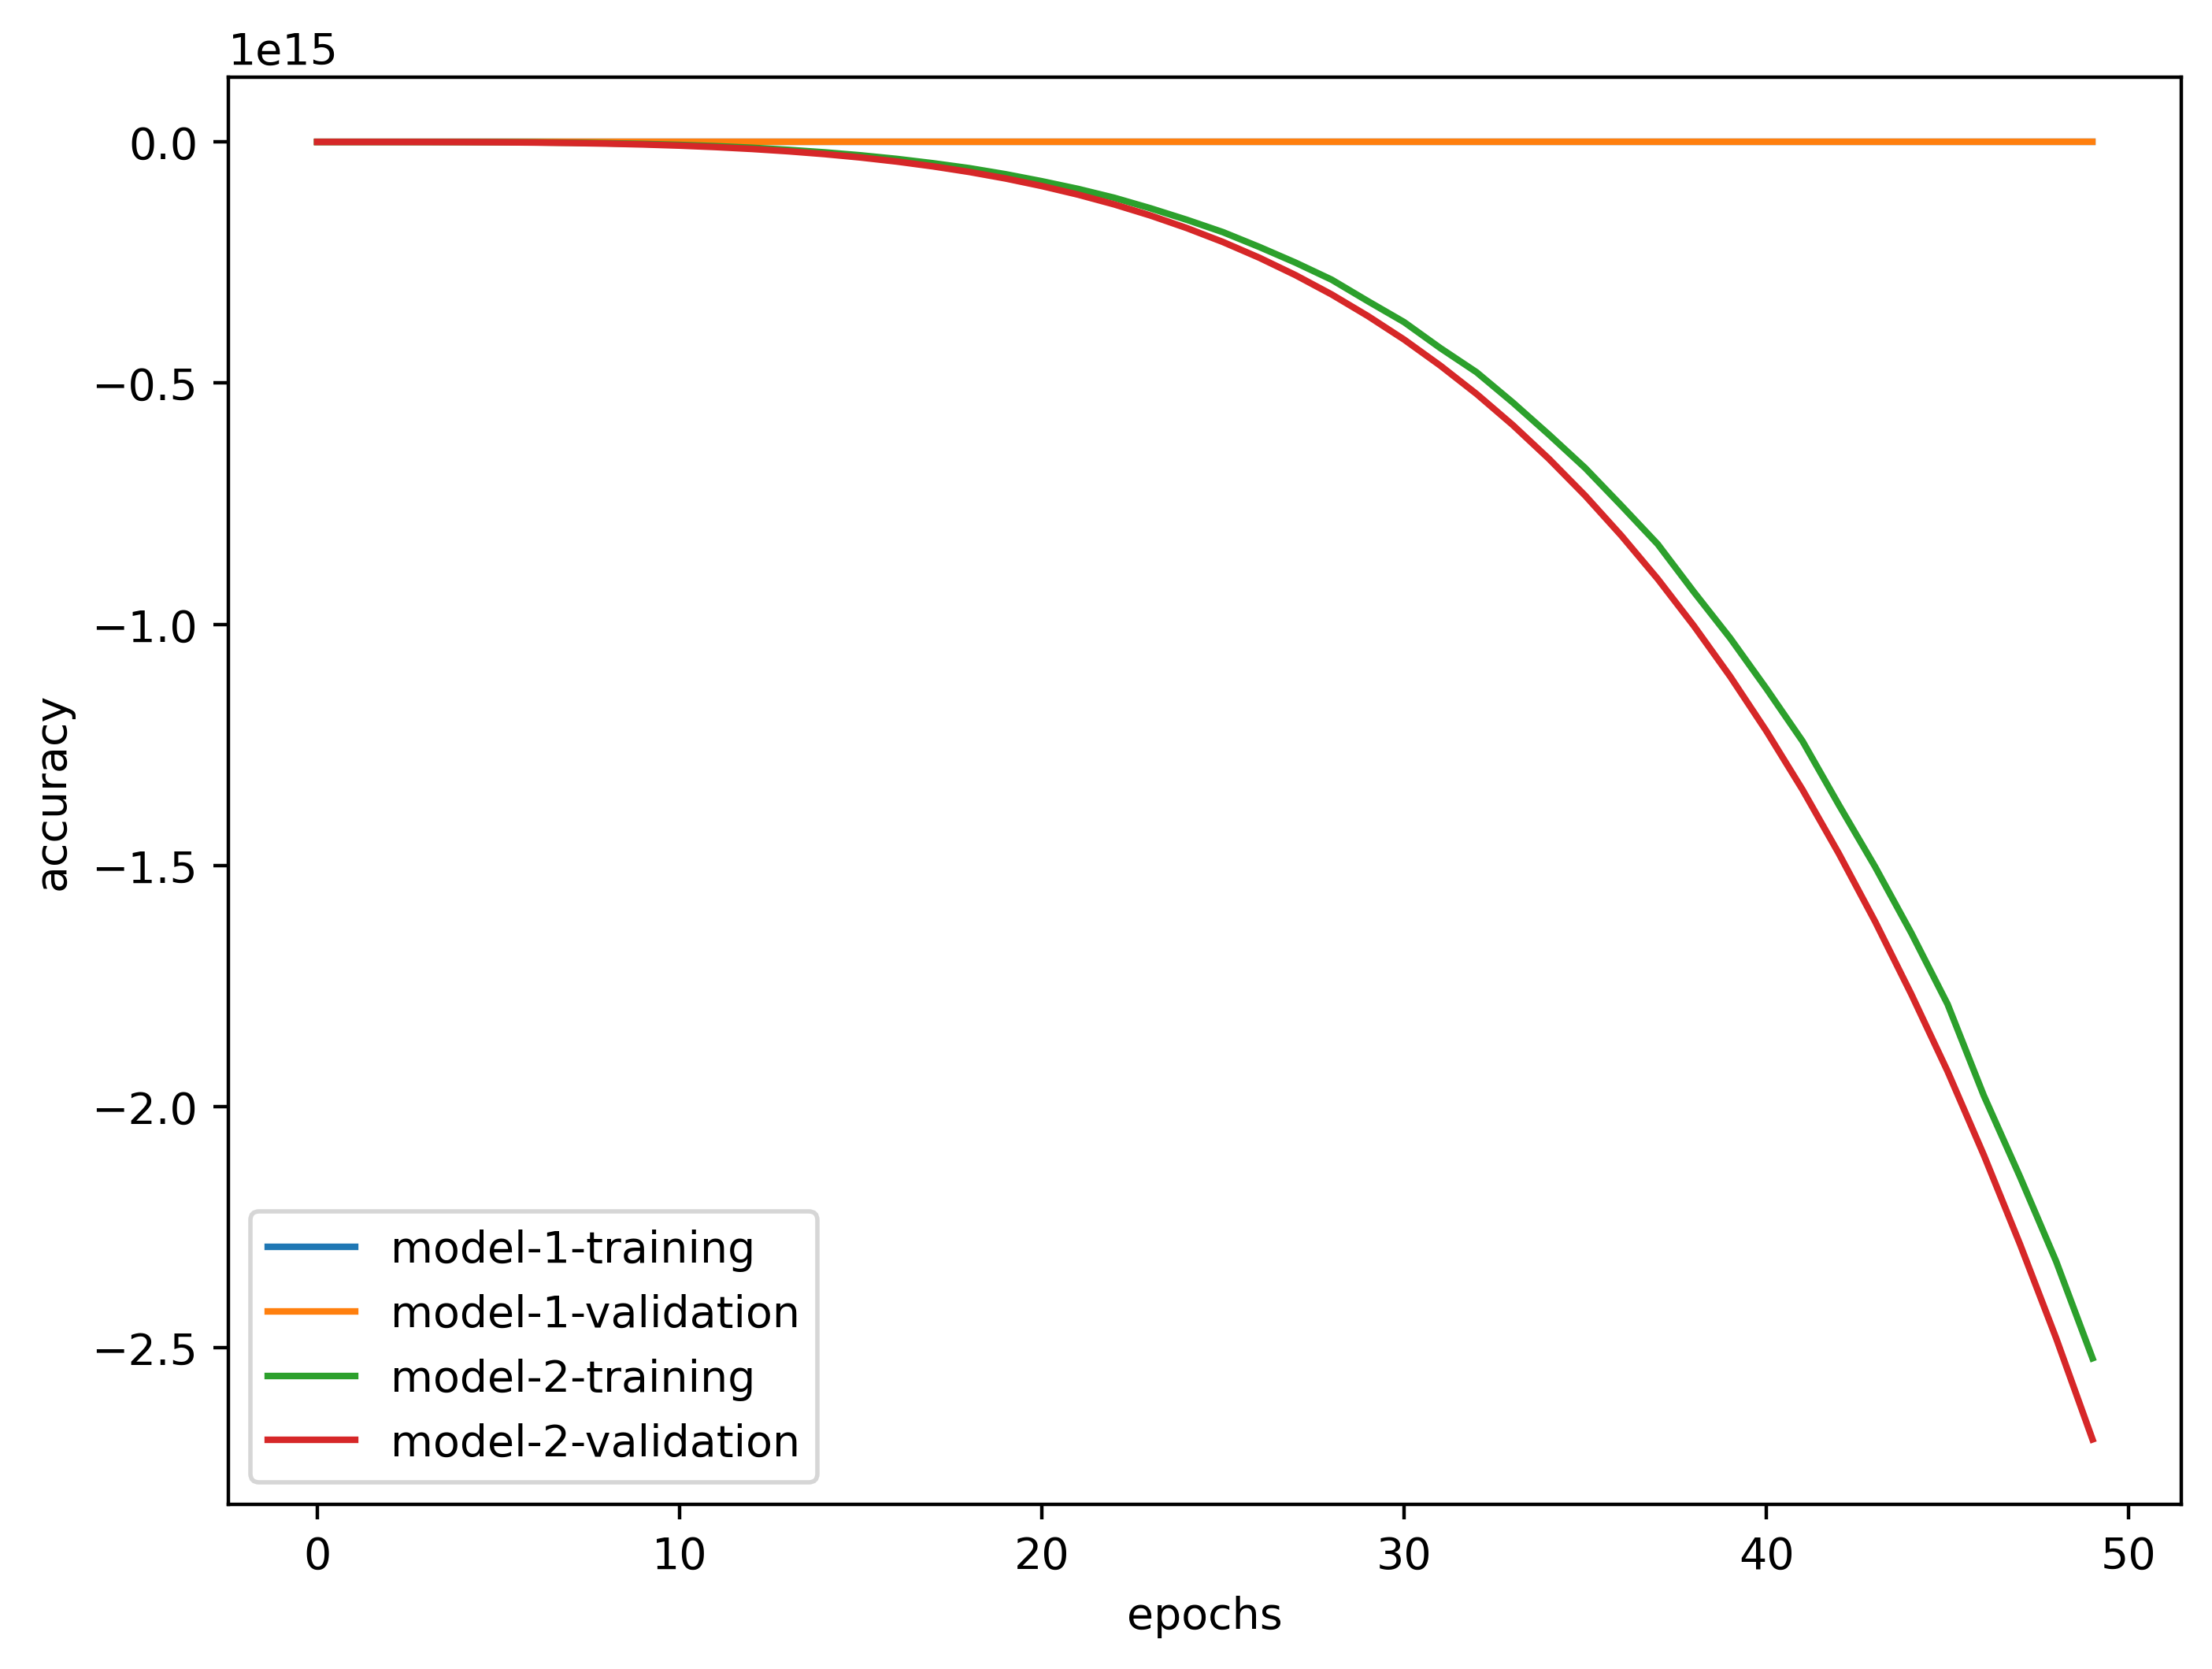

In [45]:
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(history_1.history['loss'], label='model-1-training')
plt.plot(history_1.history['val_loss'], label='model-1-validation')
plt.plot(history_2.history['loss'], label='model-2-training')
plt.plot(history_2.history['val_loss'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

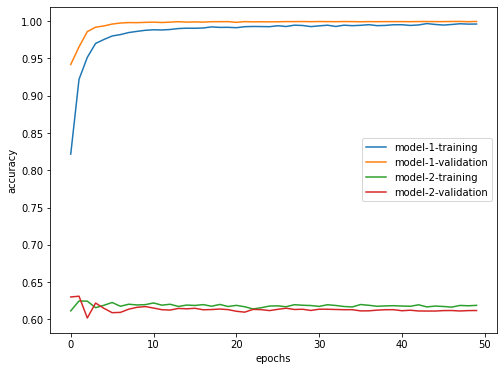

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['binary_accuracy'], label='model-1-training')
plt.plot(history_1.history['val_binary_accuracy'], label='model-1-validation')
plt.plot(history_2.history['binary_accuracy'], label='model-2-training')
plt.plot(history_2.history['val_binary_accuracy'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()